<a href="https://colab.research.google.com/github/alaguilarunal/approximate_counting/blob/main/work2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import numpy
import math
import time
from random import randint,choice,sample
from collections.abc import Callable
import networkx as nx
import pandas as pd

#Definición de clases y metodos auxiliares

Se definen las clases y sus rutinas para la generación de los látices, la función de actualización, el Gibbs sampler, y una serie de rutinas para el calculo de las configuraciones factibles exactas del  látice que se este evaluando.

In [16]:
LatticeEdge = tuple[int, int] # Clase que representa las aristas
# Una arista entre a y b es una tupla (a, b).

def update_function(neighbors):
  min_color=min(neighbors)
  min_value_colors=[i for i in range(len(neighbors)) if neighbors[i] == min_color]
  return choice(min_value_colors)

def count_valid_qcoloring(graph_list):
  valid_q_coloring=0
  for g in graph_list:
    if g.valid_q_coloring():
      valid_q_coloring+=1
  return valid_q_coloring

def all_possible_edges(k: int) -> set[LatticeEdge]:
    possible_edges = set()
    # Genera las aristas horizontales del grafo
    for x in range(0, k - 1):
        for y in range(0, k):
            node_a = k * y + x
            node_b = node_a + 1
            possible_edges.add((node_a, node_b))
        # Genera las aristas verticales del grafo
    for y in range(0, k - 1):
        for x in range(0, k):
            node_a = k * y + x
            node_b = node_a + k
            possible_edges.add((node_a, node_b))
    return possible_edges

In [17]:
# Reimplementacion:

def graph_colors(k : int, q : int) -> list[int]:
  """
  Dados el tamaño del grafo (kxk)
  y la cantidad de colores a usar (q)
  retorna una lista G_colors
  representando los colores de cada vertice del grafo.
  """

  G_colors = [randint(0, q - 1) for _ in range(k * k)]

  return G_colors

def graph_edges(k : int, amount_edges = -1) -> list[LatticeEdge]:
  """
  Dados el tamaño del grafo (kxk)
  y la cantidad de aristas deseadas

  Retorna una lista de tuplas de numeros
  G_edges representando las aristas del grafo.
  """

  all_edges = list(all_possible_edges(k))

  if amount_edges < 0:
    amount_edges = randint(0, len(all_edges) - 1)

  G_edges = sample(all_edges, amount_edges)

  return G_edges

def choose_edge_at_random(k : int) -> LatticeEdge:
  """
  Retorna una arista al azar de un grafo (kxk)
  """

  all_edges = list(all_possible_edges(k))
  return choice(all_edges)

def graph_adjacency_list(k : int, edges : list[LatticeEdge]) -> list[list[int]]:
  """
  Dados el tamaño del grafo (kxk) y una lista de
  aristas del grafo (edges), retorna la lista de adyacencia
  representando al grafo.
  """

  G = [[] for _ in range(k * k)]
  for edge in edges:
    a, b = edge
    G[a].append(b) # El nodo b es vecino de a
    G[b].append(a) # El nodo a es vecino de b

  return G

def gibbs_step(node : int, q : int, graph_colors : list[int], graph_adjacency : list[list[int]]):
  """
  Dados un nodo del grafo (node),
  La cantidad de colores usados en el grafo (q),
  la lista de colores de los vertices del grafo (graph_colors)
  y la lista de vecinos de cada nodo en el grafo (graph_adjacency)

  Modifica el color del nodo dado en la lista de colores de los vertices del grafo.
  """

  new_color = randint(0, q - 1)
  neighbors = graph_adjacency[node]
  colors_used = [] # Colores que no puede tener el nodo actual

  for neighbor in neighbors:
    colors_used.append(graph_colors[neighbor])

  while new_color in colors_used:
    new_color = randint(0, q - 1)

  # Cambiamos el color del nodo por el nuevo color:
  graph_colors[node] = new_color

def valid_graph_coloring(graph_colors : list[int], graph_adjacency : list[list[int]]) -> bool:
  """
  Dado un grafo q-coloreado (Colores de los vertices, vecinos de cada vertice)

  Retorna True si el coloreado es un q-coloreado válido; es decir, si
  cada nodo tiene un color diferente al color de sus vecinos.
  """

  total_nodes = len(graph_colors)
  for node in range(total_nodes):
    neighbors = graph_adjacency[node]
    for neighbor in neighbors:
      if graph_colors[node] == graph_colors[neighbor]:
        return False # Si un nodo tiene el mismo color que un vecino, el coloreo no es valido.

  return True

In [18]:
# Reimplementacion de la simulacion:

def simulation_gibbs(k : int, q : int, err : float, total_simulations : int, gibbs_steps_per_simulation = -1):
  """
  Dados el tamaño del grafo (k x k),
  la cantidad de colores a usar (q),
  un valor de error (err),
  la cantidad total de simulaciones a realizar (total_simulations)
  y la cantidad de gibbs_steps por simulacion (gibbs_steps_per_simulation)

  Genera un grafo por cada simulacion a realizar, y realiza los pasos
  para q-colorearlo correctamente.
  """

  # Del total de grafos generados, contaremos cuantos de ellos
  # son correctamente q-coloreados luego de hacer los gibbs_steps.
  valid_qcolorings = 0

  # Todos los grafos de la simulacion comenzarán
  # Conectados de la misma manera
  edges = graph_edges(k)

  # Luego de los gibbs_steps, a cada grafo se le añadirá una
  # arista nueva fuera del grafo, esto podria impactar
  # el total de grafos bien coloreados. Este valor es el valor deseado.

  new_edge = choose_edge_at_random(k)

  while new_edge in edges:
    new_edge = choose_edge_at_random(k)

  # Ademas, contaremos los grafos bien coloreados luego de añadir
  # la nueva arista.

  valid_qcolorings_after_new_edge = 0

  for simulation in range(total_simulations):

    # Genera un grafo de kxk vertices coloreado al azar:
    G_colors = graph_colors(k, q)
    Gadjacency = graph_adjacency_list(k, edges)
    #print(G)

    # Realizamos los gibbs_steps:
    node = 0
    steps = 0

    if gibbs_steps_per_simulation >= 0:
      while steps < gibbs_steps_per_simulation:
        gibbs_step(node, q, G_colors, Gadjacency)
        node = (node + 1) % (k * k) # Nos movemos al siguiente nodo para hacer el siguiente paso
        steps += 1
    else:
      while True:
        gibbs_step(node, q, G_colors, Gadjacency)
        node = (node + 1) % (k * k) # Nos movemos al siguiente nodo para hacer el siguiente paso
        steps += 1

        if node % (k * k) == 0:
          if valid_graph_coloring(G_colors, Gadjacency):
            break

    #print(G)

    if valid_graph_coloring(G_colors, Gadjacency):
      valid_qcolorings += 1

    Gadjacency = graph_adjacency_list(k, edges + [new_edge])

    if valid_graph_coloring(G_colors, Gadjacency):
      valid_qcolorings_after_new_edge += 1

  success_colorings_percentage = valid_qcolorings / total_simulations
  return valid_qcolorings, valid_qcolorings_after_new_edge, valid_qcolorings_after_new_edge / valid_qcolorings

In [19]:
def calculateYj(k :int, q: int):
  all_edges = list(all_possible_edges(k))
  number_inner_edges = len(all_edges)

  l = [simulation_gibbs(k, q, 1.0, 1000)[2] for _ in range(number_inner_edges)]
  average = numpy.sum(l) / number_inner_edges

  return (numpy.prod(l), average, average ** number_inner_edges)

"""
print(simulation_gibbs(2, 9, 1, 1000))
print(simulation_gibbs(2, 9, 1, 2000))
print(simulation_gibbs(2, 9, 1, 3000))
print(simulation_gibbs(2, 9, 1, 4000))
"""

print(calculateYj(3, 9))

(0.2262417134332645, 0.8835833333333335, 0.22644888379624584)


In [20]:

class ColourNode:
    __slots__ = ('colour', 'neighbors', 'neighbors_colour_count')

    def __init__(self, colour_count: int) -> None:
        # Asigna un color aleatorio al nodo entre 0 y colour_count-1
        self.colour = randint(0, colour_count - 1)
        # Inicializa la lista de vecinos
        self.neighbors = []
        # Inicializa el conteo de colores de los vecinos con ceros
        self.neighbors_colour_count = [0] * colour_count

    # Método para interconectar este nodo con otro nodo
    def inteconnect_neighbor(self, neighbor: 'ColourNode') -> None:
        # Añade el nodo vecino a la lista de vecinos
        self.neighbors.append(neighbor)
        # Añade este nodo a la lista de vecinos del nodo vecino
        neighbor.neighbors.append(self)
        # Actualiza el conteo de colores de los vecinos para ambos nodos
        self.__add_colour_count(neighbor.colour)
        neighbor.__add_colour_count(self.colour)

    # Método privado para incrementar el conteo de un color específico entre los vecinos
    def __add_colour_count(self, colour: int) -> None:
        self.neighbors_colour_count[colour] += 1

    # Método privado para decrementar el conteo de un color específico entre los vecinos
    def __subtract_colour_count(self, colour: int) -> None:
        self.neighbors_colour_count[colour] -= 1

    # Método para verificar si el color actual del nodo es válido (único entre sus vecinos)
    def valid_coloring(self) -> bool:
        # Devuelve True si ningún vecino tiene el mismo color
        return not bool(self.neighbors_colour_count[self.colour])

    # Método para actualizar el color del nodo utilizando una función de actualización proporcionada
    def update_colour(self, upd_func: Callable[[list[int]], int]) -> None:
        # Guarda el color antiguo del nodo
        old_colour = self.colour
        # Obtiene la lista de conteos de colores de los vecinos
        neighbors_colour_count = self.neighbors_colour_count
        # Calcula el nuevo color usando la función de actualización
        new_colour = upd_func(neighbors_colour_count)
        # Actualiza el conteo de colores en los vecinos
        for neighbor in self.neighbors:
            neighbor.__subtract_colour_count(old_colour)
            neighbor.__add_colour_count(new_colour)
        # Asigna el nuevo color al nodo
        self.colour = new_colour

#clase para representar el grafo de nodos coloreados
class ColourGraph:
    __slots__ = ('nodes', "side_size", 'edges', 'step')

    def __init__(
          self, side_size: int, colour_count: int,
          edges: set[LatticeEdge]) -> None:
      self.side_size = side_size
      self.edges = edges
      self.step = 0
      # Crea los nodos del grafo, inicializándolos con el número de colores proporcionado
      self.nodes = [ColourNode(colour_count) for _ in range(side_size * side_size)]
      self.__apply_edges()

    # Método privado para conectar los nodos según las aristas proporcionadas
    def __apply_edges(self) -> None:
      for edge in self.edges:
        # Obtiene los índices de los nodos a conectar
        index1, index2 = edge
        # Conecta los nodos correspondientes
        self.nodes[index1].inteconnect_neighbor(self.nodes[index2])

    # Método para obtener una copia de la lista de aristas
    def get_edges(self) -> set[LatticeEdge]:
        return self.edges.copy()

    # Método para realizar un paso del algoritmo de Gibbs
    def sys_gibbs_step(self) -> None:
      # Actualiza el color del nodo en la posición actual del paso
      self.nodes[self.step].update_colour(update_function)
      # Incrementa el paso, utilizando el operador módulo para reiniciar el contador
      self.step = (self.step + 1) % len(self.nodes)

    # Método para verificar si todos los nodos tienen un coloreado válido
    def valid_q_coloring(self):
      # Devuelve True si todos los nodos tienen un coloreado válido
      return all(node.valid_coloring() for node in self.nodes)

    # Método para elegir una nueva arista al azar
    def random_edge(self) -> LatticeEdge:
        # Selecciona una arista al azar
        possible_edges = all_possible_edges(self.side_size)
        edge = choice(possible_edges)
        # agrega la arista a la lista de aristas
        self.edges.add(edge)
        # crea la conexion correspondiente
        index_a, index_b = edge
        self.nodes[index_a].inteconnect_neighbor(self.nodes[index_b])
        return(edge)

    # Método para indicar una arista
    def create_edge(self, edge: LatticeEdge) -> None:
        # agrega la arista a la lista de aristas
        self.edges.add(edge)
        # crea la conexion correspondiente
        index_a, index_b = edge
        self.nodes[index_a].inteconnect_neighbor(self.nodes[index_b])


def simulate_samples(samples_list: list[ColourGraph], sampler_steps: int) -> None:
    for graph in samples_list:
        for _ in range(sampler_steps):
            graph.sys_gibbs_step()

Código para conteo exacto de coloraciones. **Nota:** Debido a la explosión combinatoria de los grapfós grandes, no es particularmente eficiente.

In [21]:
def create_grid_graph(n):
    G = nx.grid_2d_graph(n, n)
    G = nx.convert_node_labels_to_integers(G)
    return G

def chromatic_polynomial(G, q, memo=None):
    if memo is None:
        memo = {}
    # Memoization to avoid redundant calculations
    G_hash = nx.weisfeiler_lehman_graph_hash(G)
    if (G_hash, q) in memo:
        return memo[(G_hash, q)]

    if G.number_of_edges() == 0:
        return q ** G.number_of_nodes()

    e = list(G.edges())[0]
    G_minus_e = G.copy()
    G_minus_e.remove_edge(*e)

    G_contracted_e = nx.contracted_edge(G, e, self_loops=False)

    P_minus_e = chromatic_polynomial(G_minus_e, q, memo)
    P_contracted_e = chromatic_polynomial(G_contracted_e, q, memo)
    result = P_minus_e - P_contracted_e
    memo[(G_hash, q)] = result
    return result

def calculate_exact_q_colors(size,colors):
  G = create_grid_graph(size)

  # Calcular el número total de coloraciones posibles
  total_nodes = G.number_of_nodes()
  total_colorings = colors ** total_nodes

  # Calcular el número de coloraciones válidas
  P_G_q = chromatic_polynomial(G, colors)
  return total_colorings,P_G_q,P_G_q/total_colorings

#Implementación de la solución

El siguiente código ejecuta una simulación, valida si se cumple la condición q>2d ya partir de este resultado obtiene los pasos del gibbs sampler. Para la cantidad de muestras de la simluación se escoge 1000 debido a que para los latices que se proponen, la cantidad de muestras es muy elevada y genera grandes tiempos de computo.

In [22]:
def execute_simulation(size,colors,error):
  d=4
  init_simulations=1000
  init_gibb_sampler_steps=-1

  possible_edges = all_possible_edges(size)

  report = {
      "feasible_q_colors":[]
      #"gibb_sampler_steps_by_sample":[]
  }

  feasible_params = colors>(2*d)
  simulations=int((48*(d**3)*(size**3))/(error**2)) if feasible_params else init_simulations
  theoretical_simulations = "N/A" if init_simulations==simulations else str(simulations)
  simulations=1000 if simulations>10000 else simulations

  gibb_sampler_steps=int(size*((2*math.log(size**2)+math.log(1/error)+math.log(8))/(math.log(colors/(2*(d)))))+1) if feasible_params else init_gibb_sampler_steps
  theoretical_gibb_sampler_steps="N/A" if init_gibb_sampler_steps==gibb_sampler_steps else str(gibb_sampler_steps)

  print("Suggested simulations: ",simulations)
  print("gibb_sampler_steps:",gibb_sampler_steps if gibb_sampler_steps>0 else "N/A")

  #breakpoint()

  for i in range(0,len(possible_edges)):
    #1) Definición del conjunto de aristas a aplicar para crear las configuraciones iniciales
    app_edges = set(list(possible_edges)[0:i])

    #2) Definición de aristas disponibles para luego aplicar una en las configuraciones generadas
    available_edges = possible_edges - set(app_edges)
    #3) Generación de lista con configuraciones iniciales
    list_graphs=[ColourGraph(side_size = size, colour_count = colors, edges = app_edges) for _ in range(simulations)]

    #4) Verificar que todas las configuraciones son factibles, de lo contrario usar el gibbs sampler
    report[f"simulation_{i}"]={}
    report[f"simulation_{i}"]["gibb_sampler_steps_by_sample"]=[]

    c=0
    if count_valid_qcoloring(list_graphs)/simulations != 1:
      for q in list_graphs:
        if gibb_sampler_steps<0:
          while not q.valid_q_coloring():
            c+=1
            q.sys_gibbs_step()
        else:
          for _ in range(0,gibb_sampler_steps):
            c+=1
            q.sys_gibbs_step()

    feasible_conf = count_valid_qcoloring(list_graphs)

    #5) Selección aleatorio de una arista para conectar en las muestras iniciales
    random_edge = choice(list(available_edges)) #Escojo una arista que no este asignada a los grafos iniciales
    for g in list_graphs:
      g.create_edge(random_edge)

    #6) Validación de configuraciones factibles luego de conectar la misma arista en cada muestra
    report["feasible_q_colors"].append(count_valid_qcoloring(list_graphs)/feasible_conf)

  #print(report["feasible_q_colors"])
  return theoretical_simulations,simulations,theoretical_gibb_sampler_steps,c,numpy.prod(report["feasible_q_colors"])

In [23]:

"""size = 9
colors = 3
samples = 1000
sampler_steps = 100

error=0.01

edges = set()
report = []

possible_edges_number = 2 * (size ** 2 - size)

for _ in range(possible_edges_number):
    samples_list = [ColourGraph(size, colors, edges, update_function) for _ in range(samples)]

    simulate_samples(samples_list, sampler_steps)

    edge = samples_list[0].random_edge()
    for i in range(1, samples):
        samples_list[i].create_edge(edge)

    number_valid_qcolorings = sum((graph.valid_q_coloring() for graph in samples_list))
    report.append(number_valid_qcolorings/samples)

    edges = samples_list[0].get_edges()


for i, value in enumerate(report):
    print(f"Step {i}: {value}/{samples}")

c=1
for r in report:
  c = c*r

c"""

'size = 9\ncolors = 3\nsamples = 1000\nsampler_steps = 100\n\nerror=0.01\n\nedges = set()\nreport = []\n\npossible_edges_number = 2 * (size ** 2 - size)\n\nfor _ in range(possible_edges_number):\n    samples_list = [ColourGraph(size, colors, edges, update_function) for _ in range(samples)]\n\n    simulate_samples(samples_list, sampler_steps)\n\n    edge = samples_list[0].random_edge()\n    for i in range(1, samples):\n        samples_list[i].create_edge(edge)\n\n    number_valid_qcolorings = sum((graph.valid_q_coloring() for graph in samples_list))\n    report.append(number_valid_qcolorings/samples)\n\n    edges = samples_list[0].get_edges()\n\n\nfor i, value in enumerate(report):\n    print(f"Step {i}: {value}/{samples}")\n\nc=1\nfor r in report:\n  c = c*r\n\nc'

#Punto a)

Se define una lista de valores para ϵ a explora sobre una lista de tuplas cuya estructura define el grafo, el primer elemento de la tupla indica la raiz cuadrada del número de nodos del látice, y el segundo valor indica la cantidad de colores disponibles.

In [25]:
list_error=[0.1,0.05,0.025,0.01,0.0025,0.0001,0.00005,0.000001]
configurations=[
    (2,9),
    (3,9),
    (4,9),
    (4,15),
    (5,9),
    (5,15)
]

g_report=[]
i=1
start_time=0

exact_feasible_q_colors={}

for conf in configurations:
  start_time=time.time()
  for e in list_error:
    print(f"\033[93m---------Experimento #{i} vertices:{conf[0]**2}, colores: {conf[1]}, e:{e}--------\033[00m")
    r_report={
        "Vertices":conf[0]**2,
        "Colores":conf[1],
        "e":e,
        "Simulaciones teoricas":None,
        "Simulaciones realizadas":None,
        "Gibss_Sampler steps teorico":None,
        "Gibss Sampler steps realizados":None,
        #"q-colors factible":None,
        "Z_k":None,
        "Z_k exacta":None,
        "Tiempo de ejecucion (sg)":None
    }
    print("Ejecutando conteo aproximado...")
    r1,r2,r3,r4,r5=execute_simulation(conf[0],conf[1],e)
    if f"{conf[0]}{conf[1]}" not in exact_feasible_q_colors:
      print("Calculando conteo exacto...")
      total_confs,feasible_confs,prop_exact_q_colors=calculate_exact_q_colors(conf[0],conf[1])
      exact_feasible_q_colors[f"{conf[0]}{conf[1]}"]={
        "prop_exact_q_colors":prop_exact_q_colors,
        "total_confs":total_confs,
        "feasible_confs":feasible_confs
      }

    r_report["Tiempo de ejecucion (sg)"]=(time.time()-start_time)
    r_report["Simulaciones teoricas"]=r1
    r_report["Simulaciones realizadas"]=r2
    r_report["Gibss_Sampler steps teorico"]=r3
    r_report["Gibss Sampler steps realizados"]=r4
    r_report["Z_k"]=r5
    r_report["Z_k exacta"]=exact_feasible_q_colors[f"{conf[0]}{conf[1]}"]["prop_exact_q_colors"]

    print("Reporte:\n")
    print(json.dumps(r_report,indent=3))
    g_report.append(r_report)
    i+=1
#g_report

resultant_df=pd.DataFrame(g_report)
resultant_df.to_csv("result.csv")


---------Experimento #1 vertices:4, colores: 9, e:0.1--------
Ejecutando conteo aproximado...
Suggested simulations:  1000
gibb_sampler_steps: 122
Calculando conteo exacto...
Reporte:

{
   "Vertices": 4,
   "Colores": 9,
   "e": 0.1,
   "Simulaciones teoricas": "2457599",
   "Simulaciones realizadas": 1000,
   "Gibss_Sampler steps teorico": "122",
   "Gibss Sampler steps realizados": 122000,
   "Z_k": 0.61063831474,
   "Z_k exacta": 0.6255144032921811,
   "Tiempo de ejecucion (sg)": 1.1760199069976807
}
---------Experimento #2 vertices:4, colores: 9, e:0.05--------
Ejecutando conteo aproximado...
Suggested simulations:  1000
gibb_sampler_steps: 134
Reporte:

{
   "Vertices": 4,
   "Colores": 9,
   "e": 0.05,
   "Simulaciones teoricas": "9830399",
   "Simulaciones realizadas": 1000,
   "Gibss_Sampler steps teorico": "134",
   "Gibss Sampler steps realizados": 134000,
   "Z_k": 0.6072186673800001,
   "Z_k exacta": 0.6255144032921811,
   "Tiempo de ejecucion (sg)": 2.594231367111206
}
--

#Punto b)

Debido a que se puede pensar el modelo hard-core como la representación de un 2-coloración, asociando un color al estado "ocupado" y el otro color al estado "desocupado", para este punto se usa lo ya desarrollado en el punto anterior, utilizando una 2-coloracion.

Se define una lista de valores para ϵ a explora sobre una lista de tuplas cuya estructura define el grafo, el primer elemento de la tupla indica la raiz cuadrada del número de nodos del látice, y el segundo valor indica la cantidad de colores disponibles.

In [ ]:
list_error=[0.1,0.05,0.025,0.01,0.0025,0.0001,0.00005,0.000001]
configurations=[
    (2,2),
    (3,2),
    #(4,2),
    #(5,2)
]

g_report=[]
i=1
start_time=0

exact_feasible_q_colors={}

for conf in configurations:
  start_time=time.time()
  for e in list_error:
    print(f"\033[93m---------Experimento #{i} vertices:{conf[0]**2}, colores: {conf[1]}, e:{e}--------\033[00m")
    r_report={
        "Vertices":conf[0]**2,
        "Colores":conf[1],
        "e":e,
        "Simulaciones teoricas":None,
        "Simulaciones realizadas":None,
        "Gibss_Sampler steps teorico":None,
        "Gibss Sampler steps realizados":None,
        #"q-colors factible":None,
        "Z_k":None,
        "Z_k exacta":None,
        "Tiempo de ejecucion (sg)":None
    }
    print("Ejecutando conteo aproximado...")
    r1,r2,r3,r4,r5=execute_simulation(conf[0],conf[1],e)
    if f"{conf[0]}{conf[1]}" not in exact_feasible_q_colors:
      print("Calculando conteo exacto...")
      total_confs,feasible_confs,prop_exact_q_colors=calculate_exact_q_colors(conf[0],conf[1])
      exact_feasible_q_colors[f"{conf[0]}{conf[1]}"]={
        "prop_exact_q_colors":prop_exact_q_colors,
        "total_confs":total_confs,
        "feasible_confs":feasible_confs
      }

    r_report["Tiempo de ejecucion (sg)"]=(time.time()-start_time)
    r_report["Simulaciones teoricas"]=r1
    r_report["Simulaciones realizadas"]=r2
    r_report["Gibss_Sampler steps teorico"]=r3
    r_report["Gibss Sampler steps realizados"]=r4
    r_report["Z_k"]=r5
    r_report["Z_k exacta"]=exact_feasible_q_colors[f"{conf[0]}{conf[1]}"]["prop_exact_q_colors"]

    print("Reporte:\n")
    print(json.dumps(r_report,indent=3))
    g_report.append(r_report)
    i+=1
#g_report

resultant_df_hard_core=pd.DataFrame(g_report)
resultant_df_hard_core.to_csv("resultant_df_hard_core_result.csv")
resultant_df_hard_core

---------Experimento #1 vertices:4, colores: 2, e:0.1--------
Ejecutando conteo aproximado...
Suggested simulations:  1000
gibb_sampler_steps: N/A
Calculando conteo exacto...
Reporte:

{
   "Vertices": 4,
   "Colores": 2,
   "e": 0.1,
   "Simulaciones teoricas": "N/A",
   "Simulaciones realizadas": 1000,
   "Gibss_Sampler steps teorico": "N/A",
   "Gibss Sampler steps realizados": 3920,
   "Z_k": 0.12935726,
   "Z_k exacta": 0.125,
   "Tiempo de ejecucion (sg)": 0.09415054321289062
}
---------Experimento #2 vertices:4, colores: 2, e:0.05--------
Ejecutando conteo aproximado...
Suggested simulations:  1000
gibb_sampler_steps: N/A
Reporte:

{
   "Vertices": 4,
   "Colores": 2,
   "e": 0.05,
   "Simulaciones teoricas": "N/A",
   "Simulaciones realizadas": 1000,
   "Gibss_Sampler steps teorico": "N/A",
   "Gibss Sampler steps realizados": 3780,
   "Z_k": 0.1250964,
   "Z_k exacta": 0.125,
   "Tiempo de ejecucion (sg)": 0.4090611934661865
}
---------Experimento #3 vertices:4, colores: 2, e:

,Vertices,Colores,e,Simulaciones teoricas,Simulaciones realizadas,Gibss_Sampler steps teorico,Gibss Sampler steps realizados,Z_k,Z_k exacta,Tiempo de ejecucion (sg)
0,4,2,0.100000,N/A,1000,N/A,3920,0.129357,0.125000,0.094151
1,4,2,0.050000,N/A,1000,N/A,3780,0.125096,0.125000,0.409061
2,4,2,0.025000,N/A,1000,N/A,3989,0.137433,0.125000,0.612432
3,4,2,0.010000,N/A,1000,N/A,3840,0.131326,0.125000,0.710148
4,4,2,0.002500,N/A,1000,N/A,3941,0.124008,0.125000,0.910039
5,4,2,0.000100,N/A,1000,N/A,3845,0.110757,0.125000,1.006852
6,4,2,0.000050,N/A,1000,N/A,3914,0.128179,0.125000,1.221296
7,4,2,0.000001,N/A,1000,N/A,3824,0.127411,0.125000,1.320361
8,9,2,0.100000,N/A,1000,N/A,16228,0.001931,0.003906,1.332319
9,9,2,0.050000,N/A,1000,N/A,17146,0.003882,0.003906,2.644104


#Conclusiones

Lo que se hizo en esta ejercio fue descomponer cada grafo en pasos, empezando con un grafo sin aristas y añadiendo una arista a la vez. En cada paso, calculábamos cuántas de las configuraciones válidas se mantenían válidas después de añadir la nueva arista. Luego, multiplicamos estas proporciones en cada paso para estimar el total de configuraciones factibles para el grafo completo. Este enfoque nos permitió manejar la complejidad del problema de una manera más eficiente, aunque también vimos que la precisión del resultado final depende mucho de cómo se realicen las simulaciones y de las características del grafo. El producto telescópico fue clave para conectar las estimaciones de cada paso y darnos una buena aproximación del número total de coloraciones válidas, especialmente en los casos donde el conteo exacto sería demasiado costoso en términos de tiemp

Se usaron dos enfoques: uno de conteo aproximado usando simulaciones con el método de Gibbs y otro exacto, que aunque es preciso, es mucho más costoso en términos de tiempo. Lo interesante que vimos es que cuando el número de colores q es mayor a 2, el método de conteo aproximado funcionó bastante bien, incluso para grafos de hasta 25 nodos. A medida que ajustábamos el valor del error 𝜖 el valor Z_k que obtuvimos con las simulaciones se acercaba bastante al Z_k exacto, lo que demuestra que, aunque tomaba más tiempo, las aproximaciones eran muy buenas. Sin embargo, cuando intentamos aplicar este método en el modelo hard-core con solo dos colores (q=2), la situaciónfue diferente.

En el modelo hard-core, para grafos medianos o grandes, la solución implementada tuvo problemas para aproximarse al número de coloraciones factibles, especialmente cuando el tamaño del grafo superaba los 16 nodos. Fue evidente que, en estos casos, el Gibbs sampler implementado en este trabajo no lograba converger bien, y terminamos limitándonos a grafos más pequeños, como de 9 nodos. Lo más llamativo fue que en grafos de 4x4, simplemente no pudimos obtener una buena aproximación de Z_k, al comparar Z_k con el valor exacto.

Se notó el método de conteo aproximado implementado en esta solución funciona, pero su precisión depende mucho del tamaño del grafo y del número de colores que estamos utilizando.

En resumen, mientras que el conteo aproximado es una herramienta útil, especialmente cuando el conteo exacto es impracticable, su rendimiento puede verse limitado en situaciones más complejas, como en el modelo hard-core con pocos colores (q=2). Esto nos lleva a pensar en la necesidad de ajustar mejor los parámetros de las simulaciones o buscar otras estrategias cuando trabajamos con grafos grandes o con restricciones severas.

A continuación se presentan los resultados obtenidos en forma de tabla para cada punto.



Resultados para el punt a)

In [26]:
d=pd.read_csv("result.csv")
d["Z_k"]=d["Z_k"].round(5)
d.iloc[:, 1:]

,Vertices,Colores,e,Simulaciones teoricas,Simulaciones realizadas,Gibss_Sampler steps teorico,Gibss Sampler steps realizados,Z_k,Z_k exacta,Tiempo de ejecucion (sg)
0,4,9,0.100000,2457599,1000,122,122000,0.61064,0.625514,1.176020
1,4,9,0.050000,9830399,1000,134,134000,0.60722,0.625514,2.594231
2,4,9,0.025000,39321599,1000,146,146000,0.64653,0.625514,3.959835
3,4,9,0.010000,245760000,1000,161,161000,0.63374,0.625514,6.342933
4,4,9,0.002500,3932160000,1000,185,185000,0.63944,0.625514,8.750316
5,4,9,0.000100,2457600000000,1000,239,239000,0.59691,0.625514,11.094462
6,4,9,0.000050,9830400000000,1000,251,251000,0.62728,0.625514,13.408384
7,4,9,0.000001,24576000000000000,1000,317,317000,0.64157,0.625514,16.495311
8,9,9,0.100000,8294399,1000,224,224000,0.24983,0.245222,9.900133
9,9,9,0.050000,33177599,1000,242,242000,0.23195,0.245222,20.339521


<Axes: xlabel='e'>

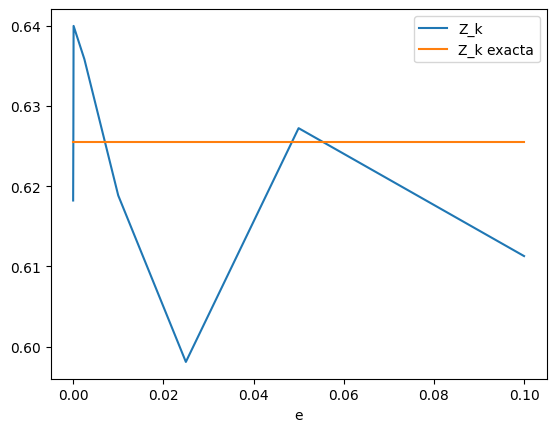

In [15]:
d=pd.read_csv("result.csv")
d["Z_k"]=d["Z_k"].round(5)
d.iloc[:8, :].plot(x="e",y=["Z_k","Z_k exacta"])

resultados para el punto b)

In [ ]:
pd.read_csv("resultant_df_hard_core_result.csv")

,Unnamed: 0,Vertices,Colores,e,Simulaciones teoricas,Simulaciones realizadas,Gibss_Sampler steps teorico,Gibss Sampler steps realizados,Z_k,Z_k exacta,Tiempo de ejecucion (sg)
0,0,4,2,0.100000,NaN,1000,NaN,3920,0.129357,0.125000,0.094151
1,1,4,2,0.050000,NaN,1000,NaN,3780,0.125096,0.125000,0.409061
2,2,4,2,0.025000,NaN,1000,NaN,3989,0.137433,0.125000,0.612432
3,3,4,2,0.010000,NaN,1000,NaN,3840,0.131326,0.125000,0.710148
4,4,4,2,0.002500,NaN,1000,NaN,3941,0.124008,0.125000,0.910039
5,5,4,2,0.000100,NaN,1000,NaN,3845,0.110757,0.125000,1.006852
6,6,4,2,0.000050,NaN,1000,NaN,3914,0.128179,0.125000,1.221296
7,7,4,2,0.000001,NaN,1000,NaN,3824,0.127411,0.125000,1.320361
8,8,9,2,0.100000,NaN,1000,NaN,16228,0.001931,0.003906,1.332319
9,9,9,2,0.050000,NaN,1000,NaN,17146,0.003882,0.003906,2.644104
